# Sateillite Image Classification Model Using EuroSAT

The focus of this project is on classifying sateillite images using the EuroSAT dataset. The goal is to train a machine learning model to differentiate between various different land types.

## Dataset Overview
EuroSAT is a dataset of satellite images captured by the Sentinel-2 satellite. It contains 10 different land cover classes, such as forests, rivers, and agricultural land. I am using the RGB images for simplicity.

## Project Steps:
1. Load the dataset
2. Preprocess the dataset
3. Visualising the dataset
4. Training a basic classification model
5. Improving the classification model
6. Evaluate performance with metrics and visualizations
7. Deploying the model

## Loading the Data

We load images from the EuroSAT_RGB folder, resizing them to 64x64 for uniformity. Images are stored as NumPy arrays, and labels are extracted from folder names.

In [1]:
import os
import numpy as np
from PIL import Image

def load_images_from_folder(folder_path, image_size=(64, 64)):
    """Loads images and their labels from the EuroSAT folder."""
    images = []
    labels = []

    # Loop through each subfolder
    for subfolder in os.listdir(folder_path):
        class_path = os.path.join(folder_path, subfolder)
        if os.path.isdir(class_path):  # Ensure it's a directory
            for file in os.listdir(class_path):
                if file.lower().endswith(('.jpg', '.png')):  # Load only JPEG or PNG files
                    img_path = os.path.join(class_path, file)
                    img_array = process_image(img_path, image_size)
                    if img_array is not None:  # Ensure valid images are processed
                        images.append(img_array)
                        labels.append(subfolder)

    return np.array(images), np.array(labels)

def process_image(image_path, image_size):
    """Resizes images and converts them to numpy arrays. Also implements error checking just in case."""
    try:
        img = Image.open(image_path)
        img = img.resize(image_size)  # Ensure consistent size
        return np.array(img)  # Convert to numpy array
    except Exception as e:
        print(f"Error processing {image_path}: {e}")
        return None

path = 'EuroSAT_RGB'
images, labels = load_images_from_folder(path)

## Preprocessing the Data

- **Normalization**: Pixel values are scaled to [0, 1] to improve model convergence.
- **Label Encoding**: Convert class names into numerical labels.
- **Train-Test Split**: The dataset is divided into 80% training, 10% validation, and 10% test sets.

In [2]:
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

def normalize_images(images):
    """Normalizes image pixel values to the range [0, 1]."""
    return images / 255.0

def encode_labels(labels):
    """Encodes string labels into integer values."""
    label_encoder = LabelEncoder()
    encoded_labels = label_encoder.fit_transform(labels)
    return encoded_labels, label_encoder  # Return encoder for inverse transformation in visualisation

def split_dataset(images, labels, val_size=0.1, test_size=0.1, random_state=42):
    """Splits the dataset into train, validate, and test sets."""
    # First, split into training and temporary
    X_train, X_temp, y_train, y_temp = train_test_split(
        images, labels, test_size=(val_size + test_size), random_state=random_state, stratify=labels
    )

    # Then, split temporary set into validation and test
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, test_size=(test_size / (val_size + test_size)), random_state=random_state, stratify=y_temp
    )

    return X_train, X_val, X_test, y_train, y_val, y_test

def print_dataset_info(X_train, X_val, X_test, y_train, y_val, y_test):
    """Prints dataset shapes and class distributions for inspection."""
    print(f"Training data shape: {X_train.shape}")
    print(f"Validation data shape: {X_val.shape}")
    print(f"Test data shape: {X_test.shape}")
    print(f"Class distribution (training): {np.bincount(y_train)}")
    print(f"Class distribution (validation): {np.bincount(y_val)}")
    print(f"Class distribution (test): {np.bincount(y_test)}")

images = normalize_images(images)
labels, label_encoder = encode_labels(labels)

X_train, X_val, X_test, y_train, y_val, y_test = split_dataset(images, labels)

print_dataset_info(X_train, X_val, X_test, y_train, y_val, y_test)


Training data shape: (21600, 64, 64, 3)
Validation data shape: (2700, 64, 64, 3)
Test data shape: (2700, 64, 64, 3)
Class distribution (training): [2400 2400 2400 2000 2000 1600 2000 2400 2000 2400]
Class distribution (validation): [300 300 300 250 250 200 250 300 250 300]
Class distribution (test): [300 300 300 250 250 200 250 300 250 300]


## Visualising Some Samples

We display sample images from the dataset along with their class labels to ensure that nothing has gone wrong in the previous steps.

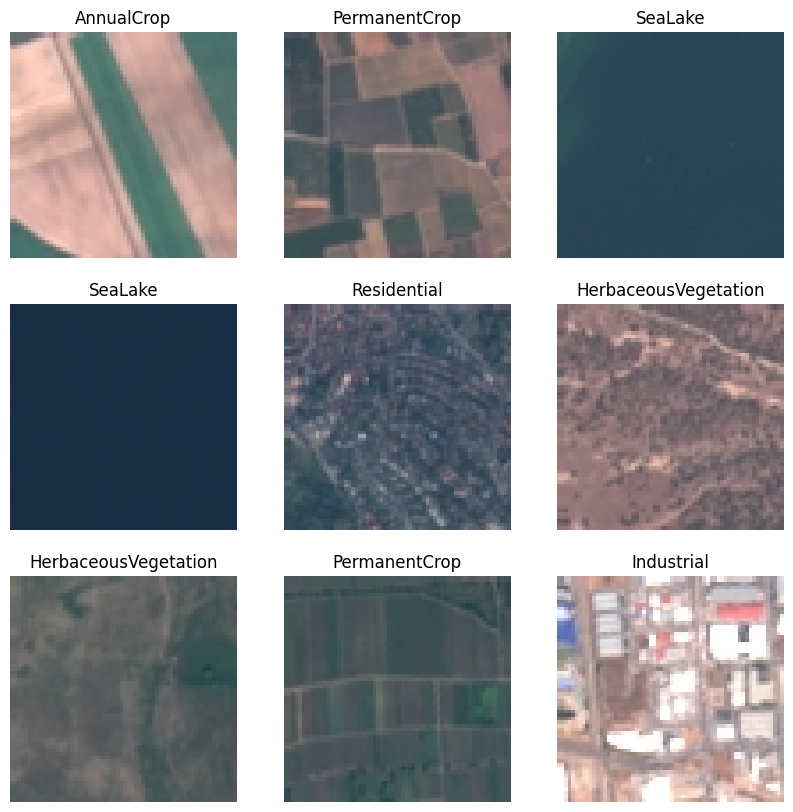

In [3]:
import matplotlib.pyplot as plt

def plot_sample_images(count=9):
    """Plot some sample images to ensure every previous step worked as intended"""
    plt.figure(figsize=(10, 10))
    for i in range(count):
        plt.subplot(3, 3, i + 1)
        plt.imshow(X_train[i])
        plt.title(label_encoder.inverse_transform([y_train[i]])[0])
        plt.axis('off')
    plt.show()

plot_sample_images()

## Training the Basic Model

We first train a basic CNN just to make sure there is nothing too wrong with the data resulting in a poor first attempt accuracy before training the larger, more time consuming model.

In [4]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Function to build the CNN model
def build_model(input_shape=(64, 64, 3), num_classes=10):
    """Creates and returns the CNN model."""
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape), # Extraction
        layers.MaxPooling2D((2, 2)), # Downsampling
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(), # Convert to dense
        layers.Dense(64, activation='relu'),
        layers.Dense(num_classes, activation='softmax') # Classification
    ])
    return model

# Function to compile the model
def compile_model(model):
    """Compiles the CNN model with adam optimizer and sparse categorical crossentropy loss"""
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy', # Used this loss function due to multi-class classification of integer-encoded labels
                  metrics=['accuracy'])

# Function to train the model
def train_model(model, X_train, y_train, X_val, y_val, epochs=10):
    """Trains the CNN model and returns the training history."""
    history = model.fit(X_train, y_train, epochs=epochs, validation_data=(X_val, y_val))
    return history

# Function to evaluate the model
def evaluate_model(model, X_test, y_test):
    """Evaluates the CNN model on the test set and prints accuracy and loss."""
    test_loss, test_acc = model.evaluate(X_test, y_test)
    print(f"Test Accuracy: {test_acc:.4f}")
    print(f"Test Loss: {test_loss:.4f}")

# Building, compiling, and training the model
model = build_model()
compile_model(model)
history = train_model(model, X_train, y_train, X_val, y_val)

# Evaluating on the test set
evaluate_model(model, X_test, y_test)

C:\Users\bench\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 15s 20ms/step - accuracy: 0.4282 - loss: 1.4989 - val_accuracy: 0.6196 - val_loss: 1.0173
Epoch 2/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 13s 20ms/step - accuracy: 0.6987 - loss: 0.8398 - val_accuracy: 0.7137 - val_loss: 0.8142
Epoch 3/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 13s 19ms/step - accuracy: 0.7483 - loss: 0.6910 - val_accuracy: 0.7344 - val_loss: 0.7283
Epoch 4/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 13s 19ms/step - accuracy: 0.7898 - loss: 0.5856 - val_accuracy: 0.8107 - val_loss: 0.5573
Epoch 5/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 13s 19ms/step - accuracy: 0.8173 - loss: 0.5151 - val_accuracy: 0.7796 - val_loss: 0.6274
Epoch 6/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 13s 20ms/step - accuracy: 0.8371 - loss: 0.4594 - val_accuracy: 0.8163 - val_loss: 0.5320
Epoch 7/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 14s 20ms/step - accuracy: 0.8561 - loss: 0.4081 - val_accuracy: 0.8067 - val_loss: 0.5750
Epoch 8/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 13s 20ms/step - accuracy: 0.8773 - loss: 0.3513 - 

## Improving the Model

While this accuracy isn't bad, the purpose of that model was to test that the machine learning method was well suited to model this data which is was. 

Using this information I will now improve the model by adding more layers and epochs.

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import models, layers, optimizers

def create_data_generator():
    """Creates an ImageDataGenerator for data augmentation to increase the size of the dataset."""
    return ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

def create_train_generator(datagen, X_train, y_train, batch_size=32):
    """Creates a training data generator."""
    return datagen.flow(X_train, y_train, batch_size=batch_size, shuffle=True)

def build_cnn(input_shape=(64, 64, 3), num_classes=10):
    """Builds and returns the CNN model."""
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

def compile_model(model, learning_rate=0.0005):
    """Compiles the model with adam optimizer and sparse categorical crossentropy loss."""
    model.compile(optimizer=optimizers.Adam(learning_rate=learning_rate),
                  loss='sparse_categorical_crossentropy', # Used this loss function due to multi-class classification of integer-encoded labels
                  metrics=['accuracy'])

def train_model(model, train_generator, X_val, y_val, epochs=57):
    """Trains the model and returns the training history."""
    history = model.fit(
        train_generator,
        epochs=epochs,
        validation_data=(X_val, y_val)
    )
    return history

datagen = create_data_generator()
train_generator = create_train_generator(datagen, X_train, y_train)

model = build_cnn()
compile_model(model)
history = train_model(model, train_generator, X_val, y_val)

Epoch 1/57


C:\Users\bench\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


675/675 ━━━━━━━━━━━━━━━━━━━━ 60s 85ms/step - accuracy: 0.3476 - loss: 2.0776 - val_accuracy: 0.5626 - val_loss: 1.1934
Epoch 2/57
675/675 ━━━━━━━━━━━━━━━━━━━━ 65s 96ms/step - accuracy: 0.5662 - loss: 1.2849 - val_accuracy: 0.3500 - val_loss: 2.5912
Epoch 3/57
675/675 ━━━━━━━━━━━━━━━━━━━━ 66s 98ms/step - accuracy: 0.6367 - loss: 1.0669 - val_accuracy: 0.6937 - val_loss: 0.8574
Epoch 4/57
675/675 ━━━━━━━━━━━━━━━━━━━━ 65s 95ms/step - accuracy: 0.6846 - loss: 0.9474 - val_accuracy: 0.5037 - val_loss: 1.7358
Epoch 5/57
675/675 ━━━━━━━━━━━━━━━━━━━━ 65s 95ms/step - accuracy: 0.7142 - loss: 0.8518 - val_accuracy: 0.6248 - val_loss: 0.9888
Epoch 6/57
675/675 ━━━━━━━━━━━━━━━━━━━━ 68s 100ms/step - accuracy: 0.7400 - loss: 0.7946 - val_accuracy: 0.7919 - val_loss: 0.6191
Epoch 7/57
675/675 ━━━━━━━━━━━━━━━━━━━━ 64s 94ms/step - accuracy: 0.7624 - loss: 0.7351 - val_accuracy: 0.7015 - val_loss: 0.8700
Epoch 8/57
675/675 ━━━━━━━━━━━━━━━━━━━━ 67s 99ms/step - accuracy: 0.7891 - loss: 0.6606 - val_accura

## Analysing the results

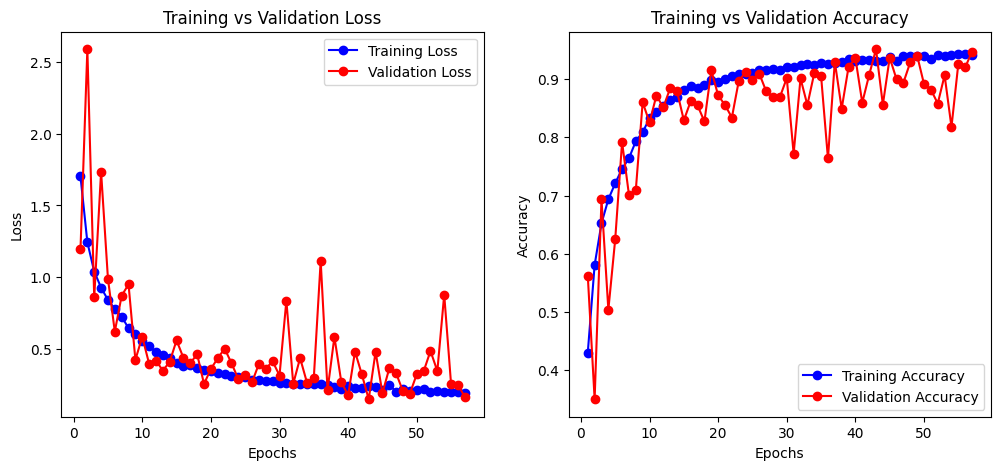

85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step


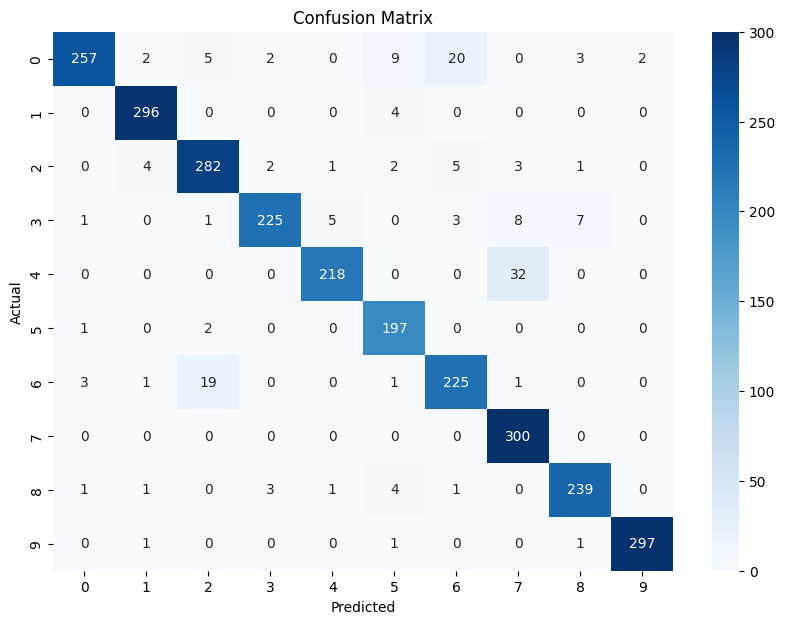

85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
              precision    recall  f1-score   support

           0       0.98      0.86      0.91       300
           1       0.97      0.99      0.98       300
           2       0.91      0.94      0.93       300
           3       0.97      0.90      0.93       250
           4       0.97      0.87      0.92       250
           5       0.90      0.98      0.94       200
           6       0.89      0.90      0.89       250
           7       0.87      1.00      0.93       300
           8       0.95      0.96      0.95       250
           9       0.99      0.99      0.99       300

    accuracy                           0.94      2700
   macro avg       0.94      0.94      0.94      2700
weighted avg       0.94      0.94      0.94      2700



In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

def plot_training_history(history):
    """Plots training, validation loss and accuracy."""
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    train_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    epochs = range(1, len(train_loss) + 1)

    plt.figure(figsize=(12, 5))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, 'bo-', label='Training Loss')
    plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training vs Validation Loss')
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_acc, 'bo-', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training vs Validation Accuracy')
    plt.legend()

    plt.show()

def plot_confusion_matrix(model, X_test, y_test, class_labels=range(10)):
    """Computes and plots the confusion matrix."""
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)  # Convert softmax outputs to class labels
    y_true_classes = y_test  # Assuming labels are already integers

    cm = confusion_matrix(y_true_classes, y_pred_classes)

    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

def print_classification_report(model, X_test, y_test):
    """Prints the classification report."""
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = y_test

    print(classification_report(y_true_classes, y_pred_classes))

# Example Usage:
plot_training_history(history)
plot_confusion_matrix(model, X_test, y_test)
print_classification_report(model, X_test, y_test)


In [8]:
model.save('my_model.keras')

## Final Thoughts

The model achieves strong accuracy but exhibits minor overfitting and some class-specific weaknesses. With regularization, fine-tuning, and possibly early stopping, the model could further improve in real-world performance but I want to move onto other projects for the time being so I will leave this as is.